In [209]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
jax.default_backend()

'cpu'

In [244]:
#generate data

x_s = np.linspace(-5,5, 30)
y_s = np.linspace(-5,5, 30)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


13500

In [245]:
X_grid

array([[-5.        , -5.        ,  0.        ],
       [-5.        , -5.        ,  0.44879895],
       [-5.        , -5.        ,  0.8975979 ],
       ...,
       [ 5.        ,  5.        ,  5.385587  ],
       [ 5.        ,  5.        ,  5.8343863 ],
       [ 5.        ,  5.        ,  6.2831855 ]], dtype=float32)

In [246]:


def uniform_samples(env, n):

    state = env.reset()
    X_rand = []
    for i in range(n):
        state = env.reset()
        X_rand.append(state)
        for action in range(env.action_space.n):
            next_state, reward, done, _ = env.step(state, action, update_env=False)
            X_rand.append(next_state)
    return np.array(X_rand)


X_samp = uniform_samples(env, 100)
X_val = uniform_samples(env,2000)


In [247]:
X = np.vstack([X_grid,X_samp])
np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

13900

In [248]:
def filter(X, get_y=None):
    filted_X = []
    for x in X:
        # calculate distance to goal and obstacle
        dist_obstacle = np.linalg.norm(x[:2] - env.obstacle_position) - env.obstacle_radius
        if dist_obstacle > 0: 
            dist_goal = np.linalg.norm(x[:2] - env.goal_position) - env.min_distance_to_goal
            if dist_goal > 0:
                filted_X.append(x)
    return np.array(filted_X)

#X = filter(X)

In [249]:
ys = [env.get_reward(x) for x in X]
    
ys = np.array(ys)

In [250]:
max(ys)

1

In [251]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [252]:
len(X)

13900

In [253]:
env.step(np.array([-2,2,np.pi]),1)

(array([-2.15102814,  2.19922476,  3.14159265]), 0, False, {})

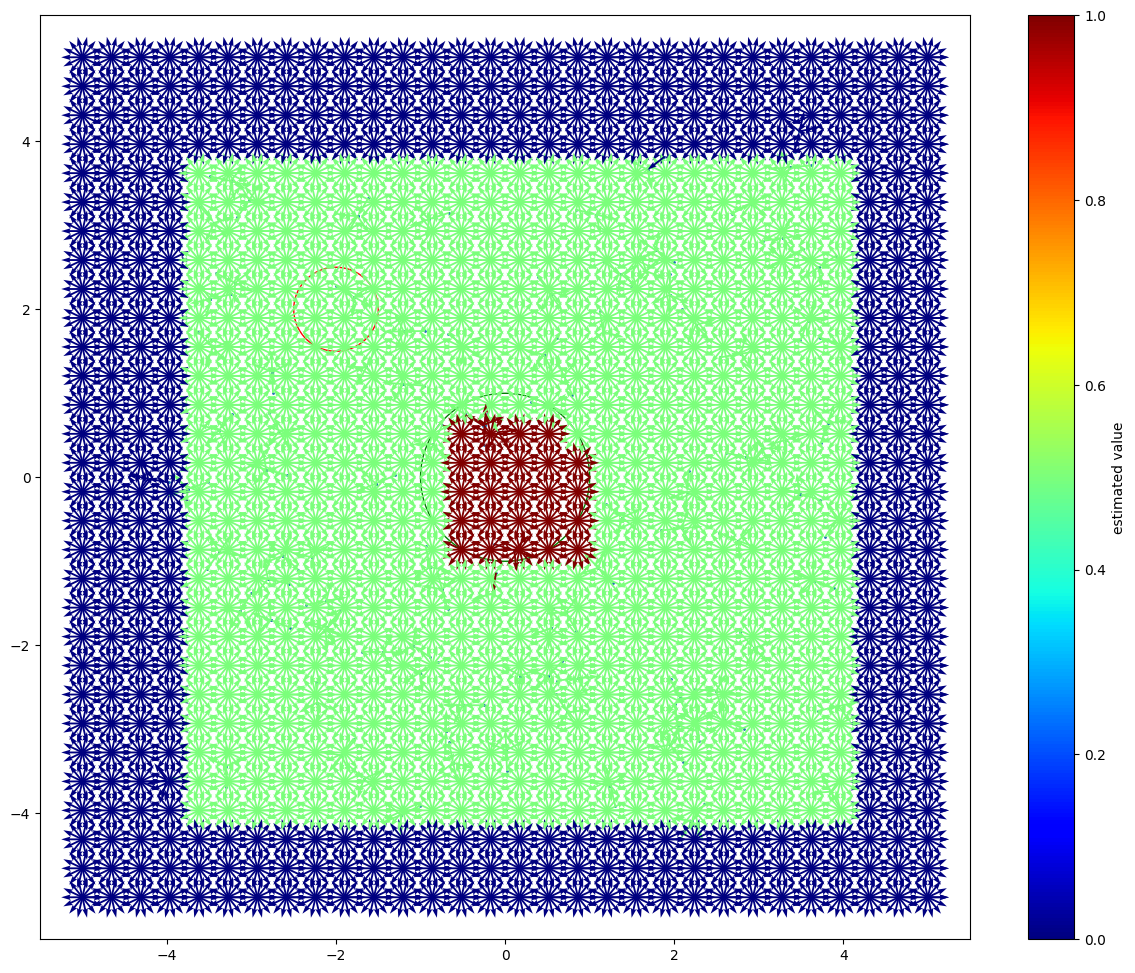

In [254]:
plot_surface(X, env, None, None, ys)

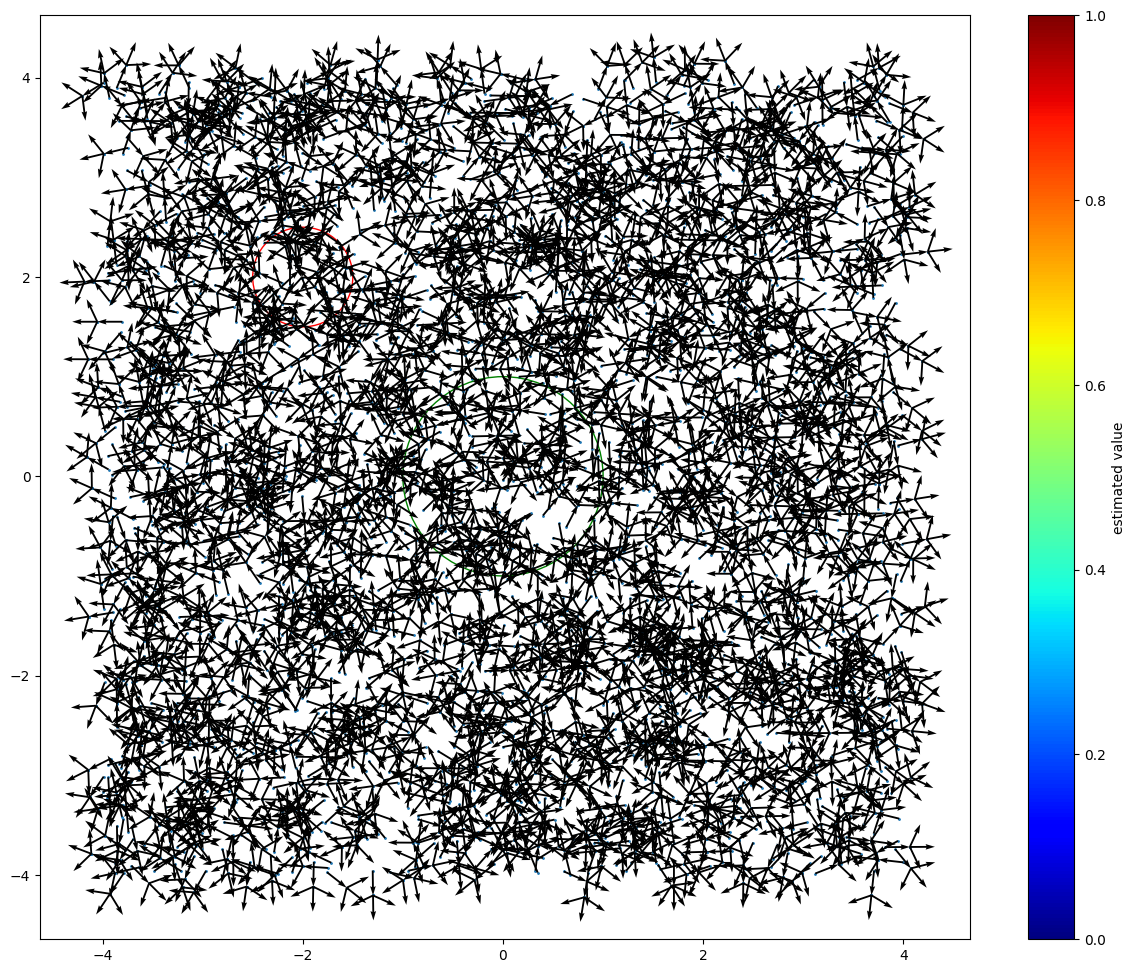

In [256]:
plot_surface(X_val, env, ys=[])

In [257]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [175]:
X

array([[-1.7241380e-01, -2.5862069e+00, -1.0000000e+00, -8.7422777e-08],
       [-3.2758620e+00, -2.9310346e+00, -9.0096885e-01,  4.3388382e-01],
       [ 1.7241380e-01, -5.1724136e-01,  1.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.2413793e+00,  5.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 5.1724136e-01,  4.3103447e+00,  2.2252098e-01,  9.7492790e-01],
       [ 2.5862069e+00,  4.3103447e+00,  9.0096885e-01,  4.3388376e-01]],
      dtype=float32)

In [16]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adabelief(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.8)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 0.82372934
epoch 1 average loss 0.8000456
epoch 2 average loss 0.7731888
epoch 3 average loss 0.7463469
epoch 4 average loss 0.720643
epoch 5 average loss 0.696386
epoch 6 average loss 0.673724
epoch 7 average loss 0.65266436
epoch 8 average loss 0.63318217
epoch 9 average loss 0.6152161
epoch 10 average loss 0.59865654
epoch 11 average loss 0.5833821
epoch 12 average loss 0.56936127
epoch 13 average loss 0.55646914
epoch 14 average loss 0.54464597
epoch 15 average loss 0.5337746
epoch 16 average loss 0.52379775
epoch 17 average loss 0.5146231
epoch 18 average loss 0.50616807


KeyboardInterrupt: 

In [258]:

def forward(X):
    l1 = hk.Linear(64)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(64)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(64)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-6)
batch_size = 200 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.99

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = False

for epoch in range(200):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = True
    epoch_loss /= (len(X) // batch_size)

    y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    val_loss = loss_fn(params, X_val, y_val)
    print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    if val_losses[-1] - val_loss < 0.0005:
        print("early stopping",val_losses[-1] - val_loss)
        break
    val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


val_loss 0.28703102 delta inf
epoch 0 average loss 0.42177483 epoch delta inf
val_loss 0.23155318 delta 0.055477843
epoch 1 average loss 0.465016 epoch delta 0.043241173
val_loss 0.18703671 delta 0.044516474
epoch 2 average loss 0.40064004 epoch delta 0.06437597
val_loss 0.1565794 delta 0.030457303
epoch 3 average loss 0.3588489 epoch delta 0.04179114
val_loss 0.13947134 delta 0.017108068
epoch 4 average loss 0.3350272 epoch delta 0.023821712
val_loss 0.13185434 delta 0.0076169968
epoch 5 average loss 0.32322332 epoch delta 0.011803865
val_loss 0.12824012 delta 0.003614217
epoch 6 average loss 0.31760368 epoch delta 0.005619645
val_loss 0.12554501 delta 0.0026951134
epoch 7 average loss 0.31421298 epoch delta 0.0033906996
val_loss 0.12332562 delta 0.0022193864
epoch 8 average loss 0.31166622 epoch delta 0.0025467575
val_loss 0.12154746 delta 0.001778163
epoch 9 average loss 0.30962443 epoch delta 0.002041787
val_loss 0.12010238 delta 0.0014450774
epoch 10 average loss 0.3079629 epoch d

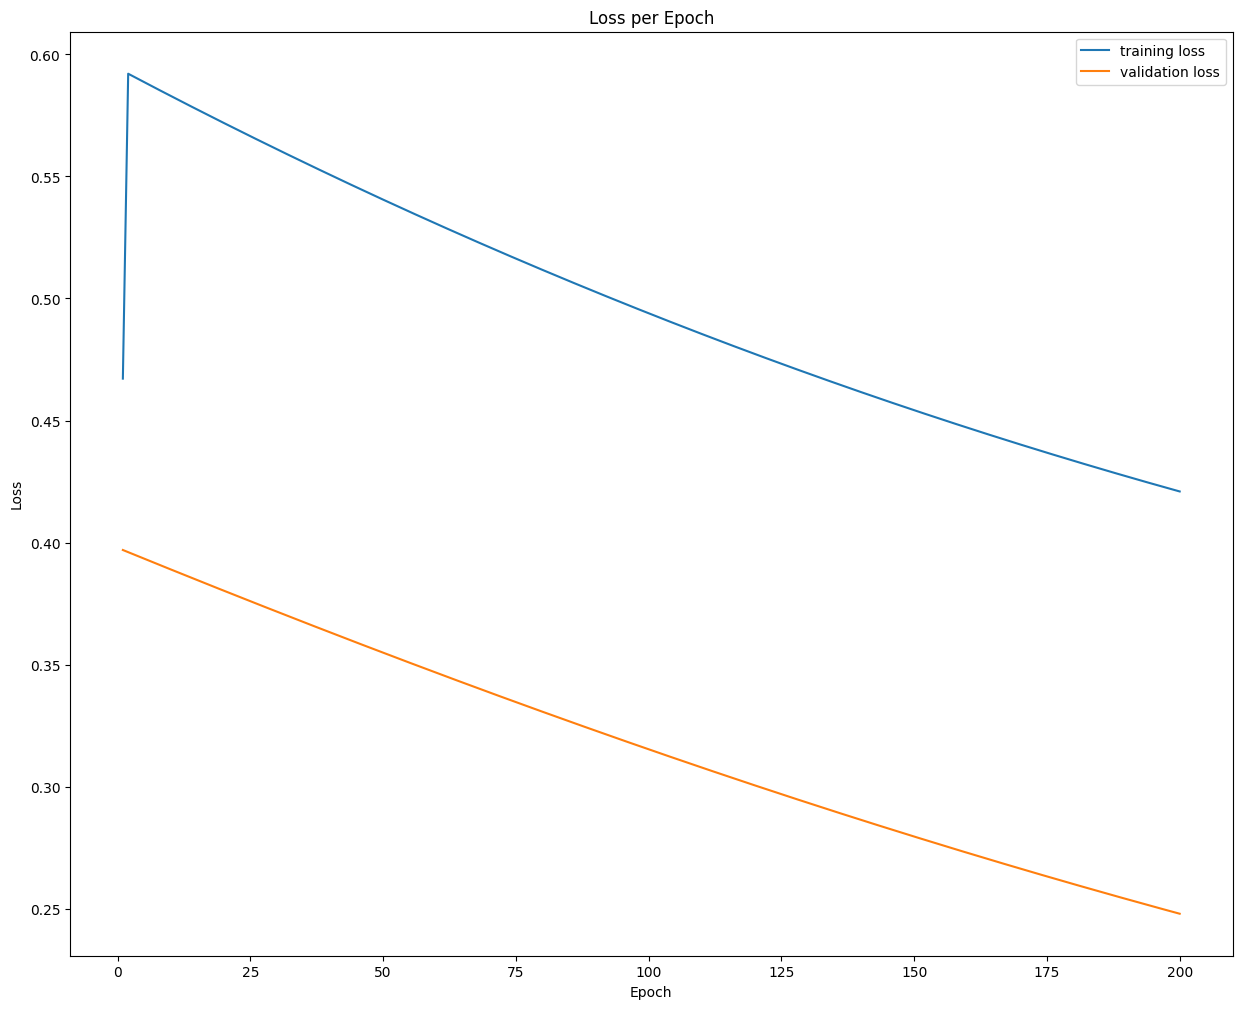

In [155]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [259]:
#generate data

x_s = np.linspace(-5,5, 20)
y_s = np.linspace(-5,5, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
X_test_encoded

array([[-5.0000000e+00, -5.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [-5.0000000e+00, -5.0000000e+00,  9.0096885e-01,  4.3388376e-01],
       [-5.0000000e+00, -5.0000000e+00,  6.2348980e-01,  7.8183150e-01],
       ...,
       [ 5.0000000e+00,  5.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 5.0000000e+00,  5.0000000e+00,  9.0096885e-01, -4.3388376e-01],
       [ 5.0000000e+00,  5.0000000e+00,  1.0000000e+00,  1.7484555e-07]],
      dtype=float32)

In [260]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

In [261]:
y_pred

[Array([-0.556977], dtype=float32),
 Array([-0.5543555], dtype=float32),
 Array([-0.53151983], dtype=float32),
 Array([-0.5026159], dtype=float32),
 Array([-0.47982135], dtype=float32),
 Array([-0.4783744], dtype=float32),
 Array([-0.4773868], dtype=float32),
 Array([-0.4690093], dtype=float32),
 Array([-0.47607434], dtype=float32),
 Array([-0.48699492], dtype=float32),
 Array([-0.54351914], dtype=float32),
 Array([-0.576817], dtype=float32),
 Array([-0.5903373], dtype=float32),
 Array([-0.5702007], dtype=float32),
 Array([-0.556977], dtype=float32),
 Array([-0.52620566], dtype=float32),
 Array([-0.51956266], dtype=float32),
 Array([-0.5032869], dtype=float32),
 Array([-0.48585206], dtype=float32),
 Array([-0.46861982], dtype=float32),
 Array([-0.47655633], dtype=float32),
 Array([-0.47477436], dtype=float32),
 Array([-0.4679437], dtype=float32),
 Array([-0.46948534], dtype=float32),
 Array([-0.47090113], dtype=float32),
 Array([-0.5261182], dtype=float32),
 Array([-0.56540895], dtype=

In [262]:
max(y_pred)

Array([0.0314387], dtype=float32)

In [263]:
min(y_pred)

Array([-0.5903373], dtype=float32)

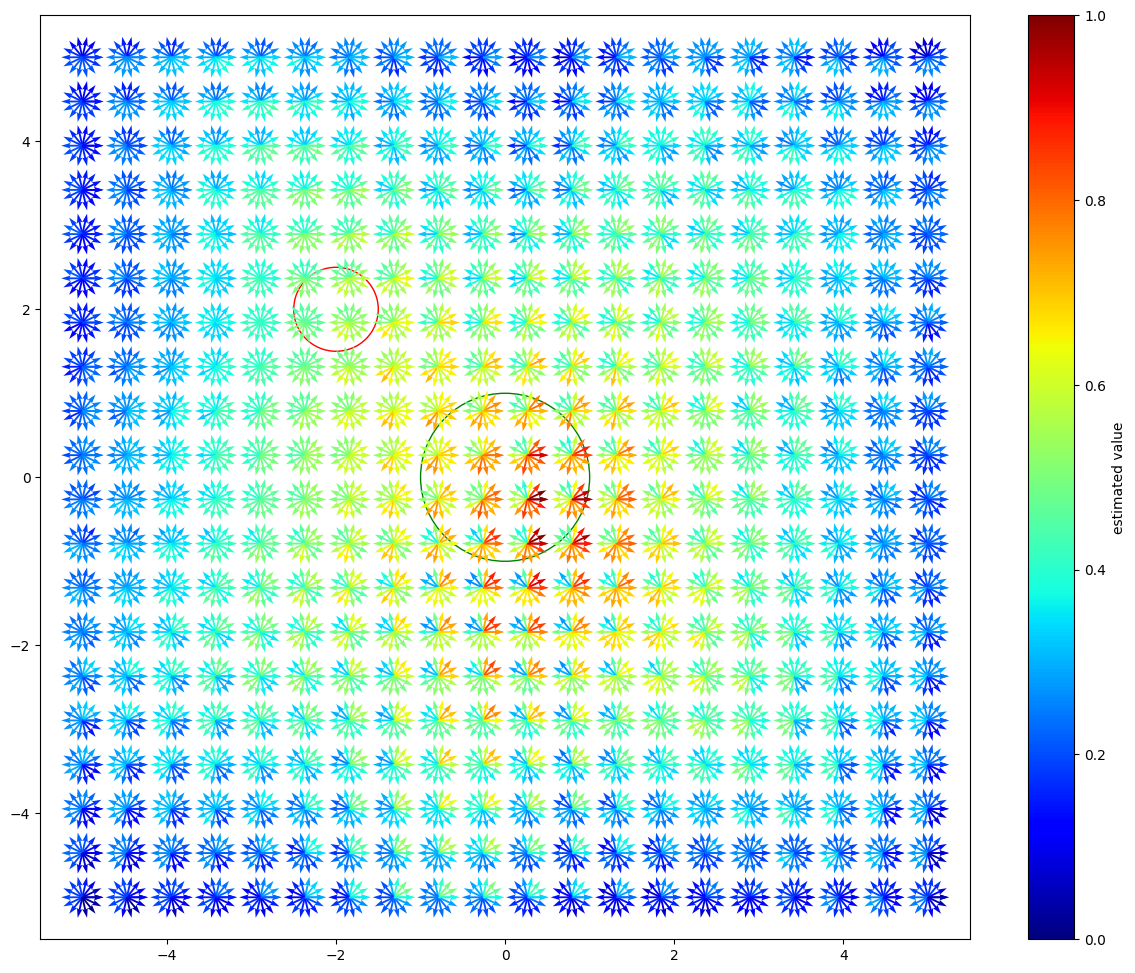

In [264]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [162]:
y_train = [forward(X=x, params=params) for x in X]

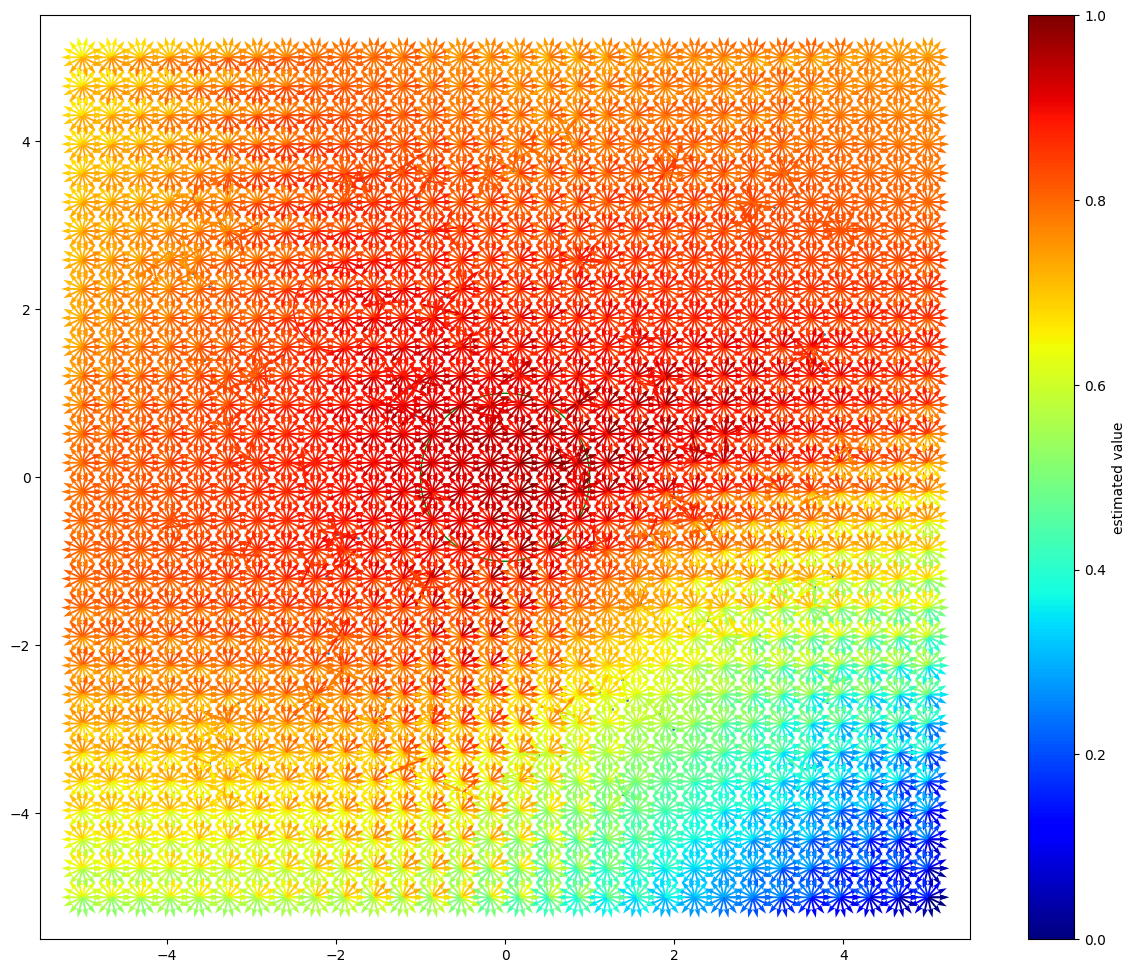

In [163]:
plot_surface(X3, env, 'experiment.png', y_train)

In [174]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(2,-2, right)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]


        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [394]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [393]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [392]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [166]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)